In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
# Verificar si TensorFlow detecta GPU
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU detectada:')
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print('No se detectó GPU. Se utilizará la CPU.')

GPU detectada:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [9]:
# Configurar para usar la GPU si está disponible
if tf.config.experimental.list_physical_devices('GPU'):
    # Limitar la cantidad de VRAM a utilizar si es necesario
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


In [10]:
# Cargar el dataset desde el archivo .pickle
archivo_pickle = 'datos_imagenes.pickle'
with open(archivo_pickle, 'rb') as f:
    df_imagenes = pickle.load(f)


In [48]:
import pandas as pd
pd_pandas = pd.read_pickle('datos_imagenes.pickle')
pd_pandas.head()

,Imagen,Etiqueta,Rostro,Landmarks
0,<PIL.Image.Image image mode=RGB size=150x150 a...,bored,"(65, 98, 108, 55)","{'chin': [(62, 83), (62, 88), (62, 93), (63, 9..."
1,<PIL.Image.Image image mode=RGB size=150x150 a...,bored,"(65, 98, 108, 55)","{'chin': [(62, 83), (62, 87), (62, 92), (63, 9..."
2,<PIL.Image.Image image mode=RGB size=150x150 a...,bored,"(66, 97, 102, 61)","{'chin': [(63, 82), (63, 87), (63, 91), (64, 9..."
3,<PIL.Image.Image image mode=RGB size=150x150 a...,bored,"(66, 97, 102, 61)","{'chin': [(63, 83), (62, 87), (63, 92), (63, 9..."
4,<PIL.Image.Image image mode=RGB size=150x150 a...,bored,"(66, 97, 102, 61)","{'chin': [(63, 83), (63, 87), (63, 92), (63, 9..."


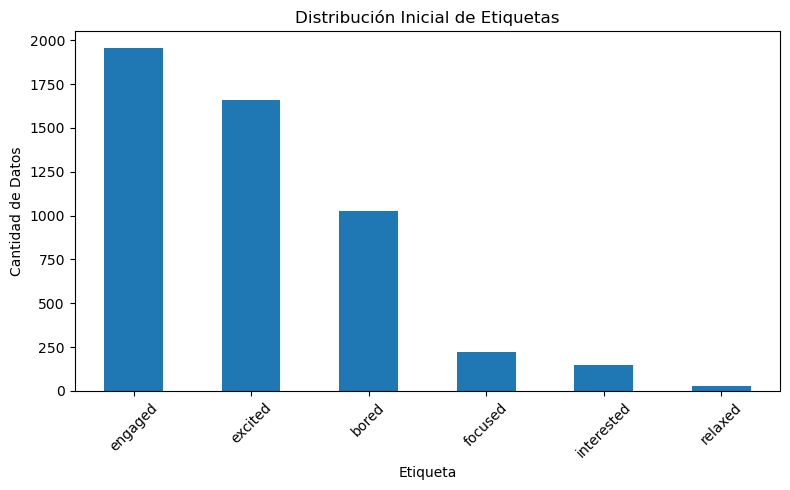

In [11]:
# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df_imagenes['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Separar las características y etiquetas
X = np.array(df_imagenes['Imagen'])
y = df_imagenes['Etiqueta']


In [13]:
# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

In [14]:
# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


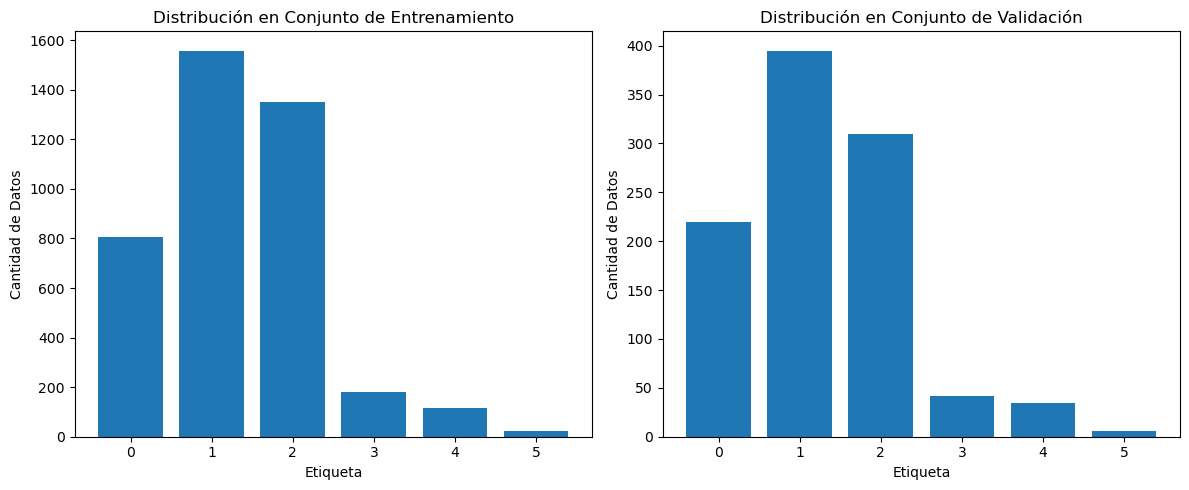

In [15]:
# Visualizar la distribución después de la división en entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(np.unique(y_train), np.bincount(y_train), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución en Conjunto de Entrenamiento')

plt.subplot(1, 2, 2)
plt.bar(np.unique(y_val), np.bincount(y_val), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución en Conjunto de Validación')

plt.tight_layout()
plt.show()

In [16]:
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

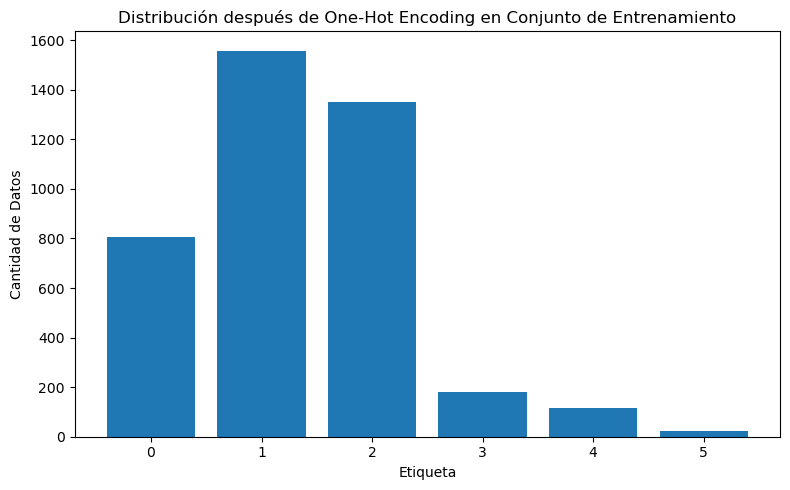

In [17]:
# Visualizar la distribución después de convertir las etiquetas a one-hot
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_train_one_hot.argmax(axis=1)), np.bincount(y_train_one_hot.argmax(axis=1)), align='center')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después de One-Hot Encoding en Conjunto de Entrenamiento')
plt.tight_layout()
plt.show()

In [18]:
# Convertir las imágenes a arrays numpy y normalizarlas
X_train = np.array([np.array(img) for img in X_train])
X_val = np.array([np.array(img) for img in X_val])

In [19]:
# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [20]:
# Definir el generador de imágenes para aumentar el dataset de entrenamiento
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [21]:
# Aumentar el dataset de entrenamiento utilizando el generador de imágenes
train_generator = datagen.flow(X_train, y_train_one_hot, batch_size=32)


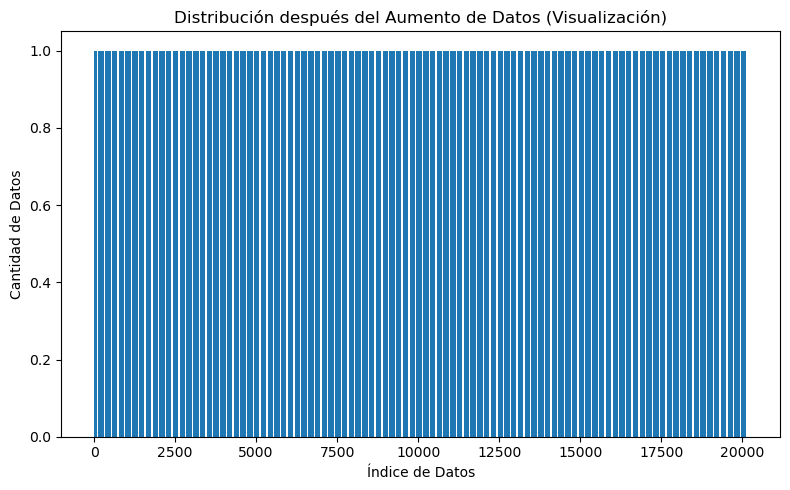

In [22]:
# Visualizar la distribución después del aumento de datos
num_aumento = 5  # Número de veces que se aplica el aumento de datos para la visualización
plt.figure(figsize=(8, 5))
plt.bar(range(len(X_train) * num_aumento), [1] * (len(X_train) * num_aumento), align='center')
plt.xlabel('Índice de Datos')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución después del Aumento de Datos (Visualización)')
plt.tight_layout()
plt.show()


In [23]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])


In [24]:
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [36]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(train_generator,
                    epochs=5,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    )


Epoch 1/5
126/126 [==============================] - 16s 125ms/step - loss: 0.7842 - accuracy: 0.6636 - val_loss: 0.7402 - val_accuracy: 0.6974
Epoch 2/5
126/126 [==============================] - 16s 128ms/step - loss: 0.7737 - accuracy: 0.6581 - val_loss: 0.7107 - val_accuracy: 0.6825
Epoch 3/5
126/126 [==============================] - 17s 132ms/step - loss: 0.7751 - accuracy: 0.6678 - val_loss: 0.7062 - val_accuracy: 0.6905
Epoch 4/5
126/126 [==============================] - 17s 134ms/step - loss: 0.7706 - accuracy: 0.6691 - val_loss: 0.7020 - val_accuracy: 0.6944
Epoch 5/5
126/126 [==============================] - 17s 133ms/step - loss: 0.7606 - accuracy: 0.6696 - val_loss: 0.7058 - val_accuracy: 0.6815


In [28]:
# Guardar el modelo
model.save('modelo_cnn.h5')

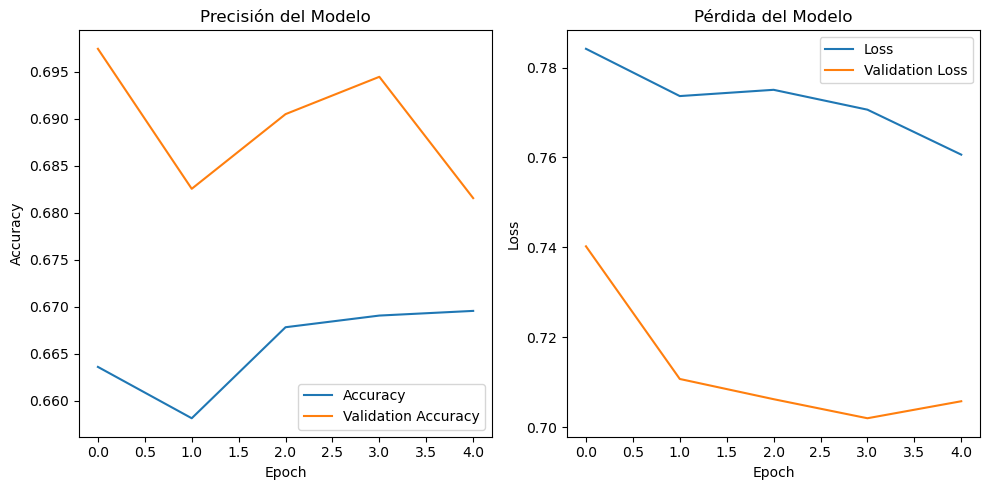

In [37]:
# Mostrar la precisión y pérdida del modelo
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Pérdida del Modelo')

plt.tight_layout()
plt.show()

In [38]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

32/32 [==============================] - 0s 10ms/step


In [39]:
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)


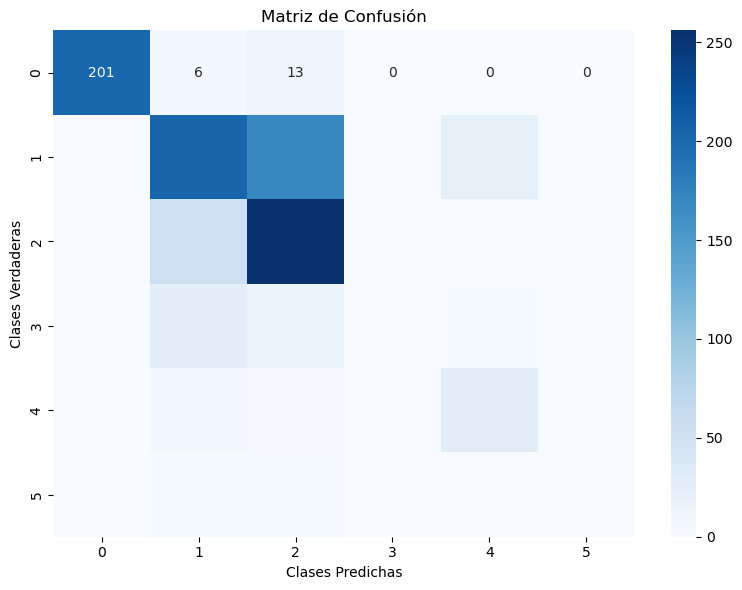

In [41]:
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [42]:
# Obtener las activaciones de las capas intermedias del modelo para una imagen de entrada
layer_outputs = [layer.output for layer in model.layers[1:]]  # Excluir la capa de entrada
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [43]:
# Obtener las activaciones para una imagen de entrada específica
sample_image = X_val[0].reshape(1, 150, 150, 3)  # Tomar la primera imagen del conjunto de validación como ejemplo
activations = activation_model.predict(sample_image)


1/1 [==============================] - 0s 96ms/step


ValueError: num must be an integer with 1 <= num <= 36, not 37

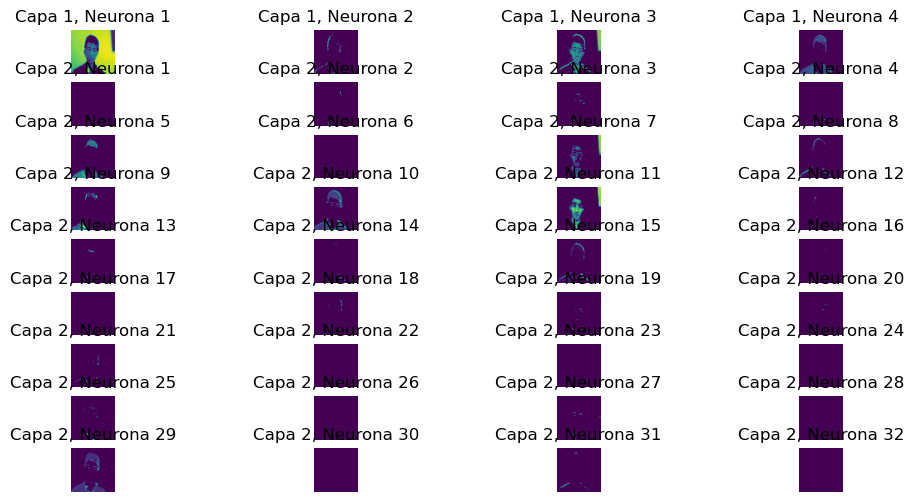

In [44]:
# Visualizar las activaciones como mapas de calor
plt.figure(figsize=(12, 6))
for i, activation_map in enumerate(activations):
    if len(activation_map.shape) == 4:  # Asegurarse de que sea un tensor 4D (por ejemplo, las activaciones de una capa Conv2D)
        for j in range(activation_map.shape[3]):
            plt.subplot(len(activations), 4, i * 4 + j + 1)
            plt.imshow(activation_map[0, :, :, j], cmap='viridis')
            plt.axis('off')
            plt.title(f'Capa {i+1}, Neurona {j+1}')
plt.tight_layout()
plt.show()